# 5.How Listings Impact: The Impact of Airbnb on the Tourism Economy
## Airbnb in Traditional vs. Non-Traditional Areas
This analysis examines how Airbnb supply influences the tourism economy in **traditional** and **non-traditional** areas.
## Tourism Economic Indicators
We developed a tourism economic indicator to measure the effects of Airbnb density, considering both local and neighbouring impacts.

In [13]:
#| echo: false
#| warning: false
#| message: false
#| results: 'hide'

import geopandas as gpd
import pandas as pd
import numpy as np
from libpysal import weights
from esda import Moran
from spreg import ML_Lag
from mapclassify import NaturalBreaks
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches

# Load spatial data
gdf = gpd.read_file("E:\\study\\CASAterm1\\CASA0013_FSDS\\group_research\\SAR data\\greater_london.gpkg")

# Load CSV data
tourism_df = pd.read_csv("E:\\study\\CASAterm1\\CASA0013_FSDS\\group_research\\SAR data\\londonT&NTlist.csv")
turnover_df = pd.read_csv("E:\\study\\CASAterm1\\CASA0013_FSDS\\group_research\\SAR data\\turnover_final_merge.csv")
listings_df = pd.read_csv("E:\\study\\CASAterm1\\CASA0013_FSDS\\group_research\\SAR data\\listings.csv")

# Rename columns for merging
gdf = gdf.rename(columns={'geo_code': 'MSOA_CODE'})
turnover_df = turnover_df.rename(columns={'geo_code':'MSOA_CODE'})

# Define tourism-related categories
tourism_categories = ['_retail', '_f&b', '_travel', '_art&ent', '_sp_recrea', '_gambling']
tourism_cols = [col for col in turnover_df.columns if any(cat in col for cat in tourism_categories)]
tourism_cols_numeric = [col for col in tourism_cols if np.issubdtype(turnover_df[col].dtype, np.number)]

# Compute a tourism economic indicator
turnover_df['tourism_economic_indicator'] = turnover_df[tourism_cols_numeric].sum(axis=1)

# Convert listings to a GeoDataFrame and reproject
listings_gdf = gpd.GeoDataFrame(
    listings_df,
    geometry=gpd.points_from_xy(listings_df['longitude'], listings_df['latitude']),
    crs="EPSG:4326"
)
listings_gdf = listings_gdf.to_crs(epsg=27700)
gdf = gdf.to_crs(epsg=27700)

# Spatial join to assign Airbnb listings to MSOA
listings_with_area = gpd.sjoin(listings_gdf, gdf, how="left", predicate="within")

# Aggregate Airbnb supply by MSOA_CODE
airbnb_supply = listings_with_area.groupby('MSOA_CODE').size().reset_index(name='airbnb_supply')

# Merge data
tourism_df_selected = turnover_df[['MSOA_CODE', 'tourism_economic_indicator']]
merged_df = tourism_df_selected.copy()
merged_df = pd.merge(merged_df, airbnb_supply, on='MSOA_CODE', how='left')
merged_df['airbnb_supply'] = merged_df['airbnb_supply'].fillna(0)
merged_df = pd.merge(merged_df, tourism_df, on='MSOA_CODE', how='left')

SARdata = gdf.merge(merged_df, on='MSOA_CODE', how='inner')

# Create interaction term
SARdata['airbnb_interact'] = SARdata['airbnb_supply'] * SARdata['hotspot_binary']

# Calculate area in hectares
SARdata['area_m2'] = SARdata.geometry.area
SARdata['area_ha'] = SARdata['area_m2'] / 10000.0
SARdata['airbnb_density_per_ha'] = SARdata['airbnb_supply'] / SARdata['area_ha']

# Prepare variables for the model
X_vars = ['airbnb_density_per_ha', 'airbnb_interact']
X = SARdata[X_vars].values
y = SARdata['tourism_economic_indicator'].values.reshape(-1,1)

# Create spatial weights
W = weights.contiguity.Queen.from_dataframe(SARdata, use_index=True)
W.transform = 'r'

# Compute Moran's I (hidden results)
mi = Moran(y.flatten(), W)

# Run SAR model (hidden results)
sar_model = ML_Lag(y, X, w=W, name_y='tourism_economic_indicator',
                   name_x=X_vars, name_w='W', method='full')

D:\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


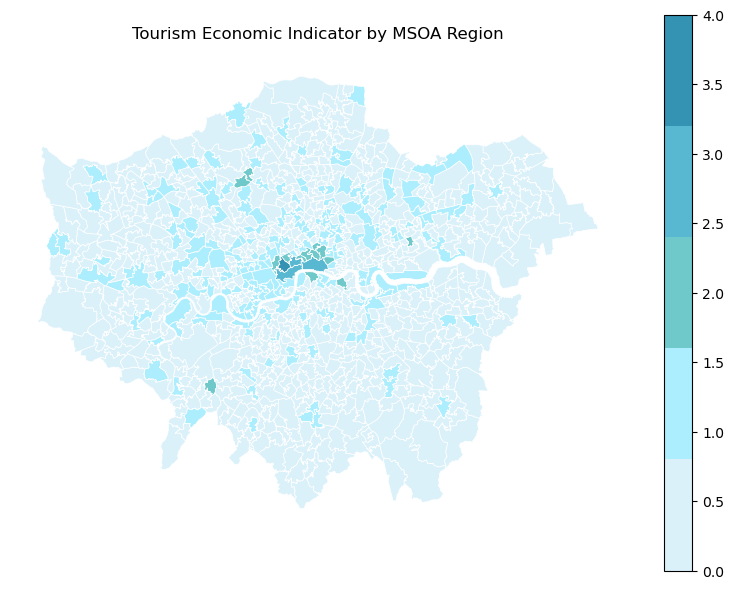

In [16]:
#| echo: false
#| warning: false
#| message: false
#| fig-width: 8
#| fig-height: 6

# Define the color palette
colors = ['#DBF1FA', '#ACEEFE', '#6FC8CA', '#58B8D1', '#3492B2']

# Use Natural Breaks for classification
nb = NaturalBreaks(SARdata['tourism_economic_indicator'], k=5)
SARdata['nb_class'] = nb.yb

# Plot the MSOA map with the natural breaks classification
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
SARdata.plot(column='nb_class', 
             cmap=mcolors.ListedColormap(colors), 
             linewidth=0.5, 
             edgecolor='white', 
             ax=ax,
             legend=True)  # Use default legend

# Add title and remove axes
ax.set_title("Tourism Economic Indicator by MSOA Region", fontsize=12, pad=12)
ax.axis("off")  # Remove axes for a cleaner map

# Display the plot
plt.tight_layout()
plt.show()

## Key Findings: Airbnb Density and Tourism Economy
Airbnb density significantly reduces tourism economic performance **(-26.87)**, especially in **non-traditional areas**. In **traditional areas**, stronger infrastructure mitigates this effect **(+0.72)**. Positive spillover effects (0.63) highlight regional interconnections, emphasising the need for **region-specific policies** and spatial planning to balance Airbnb growth and economic goals.